Continuation of the testing notebook

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def transform_board(image, rect):
    # Get the coordinates of the corners of the board
    x1, y1, x2, y2, x3, y3, x4, y4 = rect

    # Set the target size for the new image
    RESOLUTION_FACTOR = 8
    target_width = 112 * RESOLUTION_FACTOR
    target_height = 224 * RESOLUTION_FACTOR

    # Define the new coordinates of the corners in the new image
    new_rect = np.array([[0, 0], [target_width, 0], [target_width, target_height], [0, target_height]],
                        dtype=np.float32)

    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float32), new_rect)

    # Apply the perspective transformation to the original image
    transformed_image = cv2.warpPerspective(image, matrix, (target_width, target_height))

    return transformed_image

In [4]:
def show_im(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [5]:
def draw_circles(image, circles):
    if circles is not None:
        for i in circles:
            print(i)
            cv2.circle(image, (int(i[0]), int(i[1])), 20, (0, 255, 0), 3)
    return image

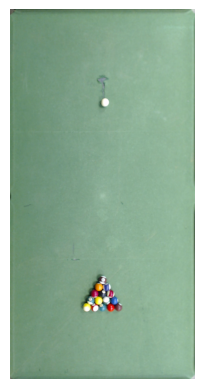

In [6]:

video_path = r"detect_objects_test_images\test_video.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

rect = [61, 944, 91, 68, 1860, 38, 1890, 937]
cropped_image = transform_board(frame, rect)
show_im(cropped_image)


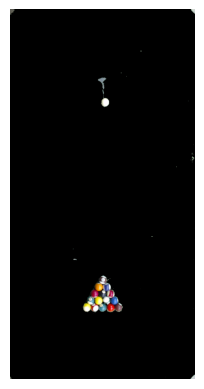

In [7]:
# remove green from the image
import copy
def remove_green(_image):
    image = copy.deepcopy(_image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    image[mask == 255] = [0, 0, 0]
    return image


show_im(remove_green(cropped_image))

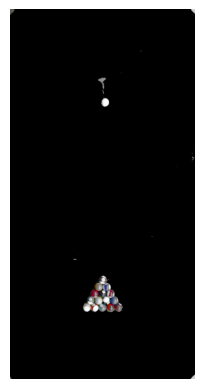

In [8]:
# for every white pixel, set the pixel to the average of the surrounding pixels
def remove_white(image):
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if np.linalg.norm(image[i, j]) >= 200 :
                image[i, j] = np.mean(image[i-1:i+2, j-1:j+2])
    return image

import copy
no_green_copy = copy.deepcopy(remove_green(cropped_image))
white_removed = remove_white(no_green_copy)
show_im(white_removed)

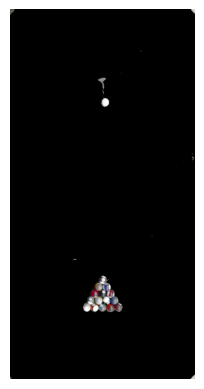

True

In [9]:
# apply bilateral filter
def bilateral_filter(image):
    return cv2.bilateralFilter(image, 9, 1, 200)

after_bilat = bilateral_filter(white_removed)
show_im(after_bilat)
cv2.imwrite("bilateral.jpg", after_bilat)


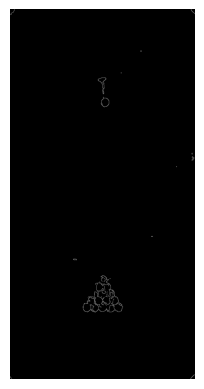

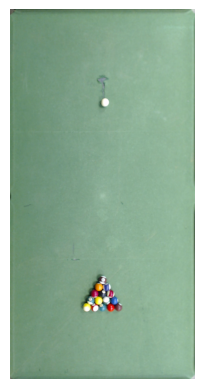

In [10]:
# apply canny edge detection
def canny_edge_detection(image):
    return cv2.Canny(image, 300, 400)

after_canny = canny_edge_detection(after_bilat)
show_im(canny_edge_detection(after_bilat))
cv2.imwrite("canny.jpg", after_canny)
show_im(cropped_image)


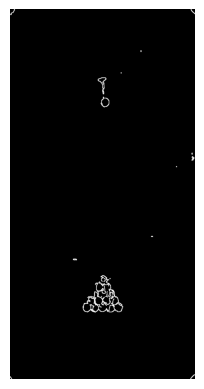

In [11]:
# dilate the edges
def dilate_edges(image):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

after_dilate = dilate_edges(after_canny)
show_im(after_dilate)

In [12]:
def hough_circles(image, min_radius, max_radius, min_dist, param1, param2):
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1.5, min_dist, param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    return circles


def find_balls(image, return_intermediates=False):
    # Remove green from the image
    no_green = remove_green(image)
    # Remove white pixels
    no_white = remove_white(no_green)
    # Apply bilateral filter
    bilat = bilateral_filter(no_white)
    # Apply canny edge detection
    canny = canny_edge_detection(bilat)
    # Apply hough circles
    circles = hough_circles(canny, 15, 30, 20, 50, 30)
    # return only the xy coordinates of the circles:
    if circles is not None:
        circles = circles[0, :][:, :2]

    if return_intermediates:
        # Return the intermediate results and the final circles
        return image, circles
    else:
        return circles

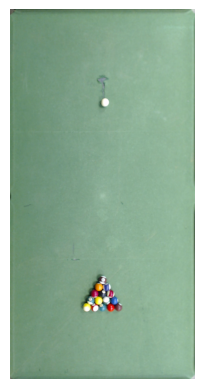

[[ 461.25  450.75]
 [ 426.75 1415.25]
 [ 372.75 1443.75]
 [ 504.75 1412.25]
 [ 428.25 1344.75]
 [ 482.25 1380.75]
 [ 408.75 1446.75]
 [ 450.75 1313.25]
 [ 459.75 1377.75]
 [ 450.75 1440.75]
 [ 387.75 1413.75]
 [ 486.75 1448.25]
 [ 465.75 1406.25]
 [ 525.75 1442.25]]
[461.25 450.75]
[ 426.75 1415.25]
[ 372.75 1443.75]
[ 504.75 1412.25]
[ 428.25 1344.75]
[ 482.25 1380.75]
[ 408.75 1446.75]
[ 450.75 1313.25]
[ 459.75 1377.75]
[ 450.75 1440.75]
[ 387.75 1413.75]
[ 486.75 1448.25]
[ 465.75 1406.25]
[ 525.75 1442.25]


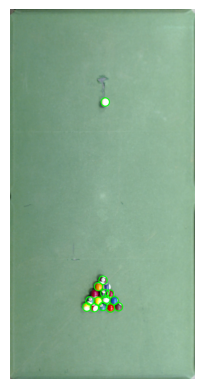

In [13]:
video_path = r"detect_objects_test_images\test_video.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

rect = [61, 944, 91, 68, 1860, 38, 1890, 937]
cropped_image = transform_board(frame, rect)
show_im(cropped_image)

circles = find_balls(cropped_image)
print(circles)
show_im(draw_circles(cropped_image, circles))

Test averageing frames

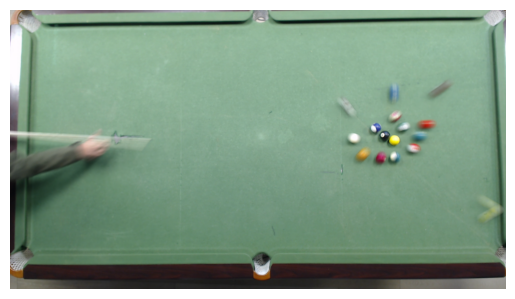

In [14]:
video_path = r"detect_objects_test_images\test_video.mp4"
cap = cv2.VideoCapture(video_path)
class FrameBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
    
    def add_frame(self, frame):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(frame)
    
    def get_average_frame(self):
        if len(self.buffer) == 0:
            return None
        average_frame = np.zeros_like(self.buffer[0], dtype=np.float32)
        for frame in self.buffer:
            average_frame += frame
        average_frame /= len(self.buffer)
        average_frame = average_frame.astype(np.uint8)
        return average_frame


    def get_buffer(self):
        return self.buffer


n = 5
buffer = FrameBuffer(n)
# skip the first 100 frames
for i in range(200):
    ret, frame = cap.read()

for i in range(n):
    ret, frame = cap.read()
    buffer.add_frame(frame)

show_im(buffer.get_average_frame())

In [15]:
# test the buffer
cap = cv2.VideoCapture(video_path)
buffer = FrameBuffer(5)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    buffer.add_frame(frame)
    average_frame = buffer.get_average_frame()
    if average_frame is not None:
        circles = find_balls(average_frame)
        if circles is not None:
            average_frame = draw_circles(average_frame, circles)
        cv2.imshow("average_frame", average_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


[1418.25  495.75]
[516.75 480.75]
[1452.75  485.25]
[1494.75  546.75]
[1515.75  405.75]
[1485.75  503.25]
[1454.25  444.75]
[1527.75  507.75]
[1518.75  558.75]
[1485.75  426.75]
[1518.75  447.75]
[1425.75  462.75]
[1485.75  465.75]
[1515.75  468.75]
[1452.75  531.75]
[441.75 513.75]
[1491.75  501.75]
[ 974.25 1001.25]
[1521.75  558.75]
[1485.75  429.75]
[1521.75  522.75]
[1418.25  495.75]
[519.75 480.75]
[1515.75  405.75]
[1443.75  465.75]
[1485.75  465.75]
[1521.75  444.75]
[1386.75  483.75]
[1488.75  540.75]
[1455.75  444.75]
[1521.75  558.75]
[1418.25  495.75]
[519.75 480.75]
[1517.25  483.75]
[1518.75  444.75]
[1521.75  522.75]
[1485.75  506.25]
[ 972.75 1005.75]
[1518.75  405.75]
[1446.75  531.75]
[1443.75  465.75]
[1482.75  426.75]
[1488.75  546.75]
[1386.75  483.75]
[441.75 513.75]


In [16]:
cv2.destroyAllWindows()